# Transformers
1. The first part of this notebook runs through the details of running a transformer model (Jeremy Howard's **[Kaggle page](https://www.kaggle.com/code/jhoward/iterate-like-a-grandmaster/)**.).

2. Then, I use ChatGPT to describe the details of transformers and I annotate the code in detail.

3. Finally, I include notes from Jay Alammar's **[Illustrated Transformer](https://jalammar.github.io/illustrated-transformer/)**.

*I suggest opening this notebook in Colab or in Kaggle.*

# Part 1. Running a Transformer Model
This is all Jeremy Howard's code.

In [83]:
# !pip install kaggle
# !pip install transformers
# !pip install datasets
# !pip install sentencepiece
# !pip install transformers[torch]
# !pip install --upgrade transformers
# !pip install --upgrade torch
# !pip install accelerate -U

In [1]:
import os
from pathlib import Path
import pandas as pd
import numpy as np
import shutil
import zipfile

from torch.utils.data import DataLoader
import warnings,transformers,logging,torch
from transformers import TrainingArguments,Trainer
from transformers import AutoModelForSequenceClassification,AutoTokenizer

import datasets
from datasets import load_dataset, Dataset, DatasetDict

# warnings
warnings.simplefilter('ignore')
logging.disable(logging.WARNING)

os.getcwd()

'/content'

In [2]:
# data is from kaggle -- set up creds
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')
creds = '{"username":"FILL IN","key":"FILL IN"}'
cred_path = Path('~/.kaggle/kaggle.json').expanduser()

if not cred_path.exists():
  cred_path.parent.mkdir(exist_ok=True)
  cred_path.write_text(creds)
  cred_path.chmod(0o600)

cred_path

PosixPath('/root/.kaggle/kaggle.json')

## Data

### Download

In [3]:
path = Path('/content/us-patent-phrase-to-phrase-matching/')
comp = 'us-patent-phrase-to-phrase-matching'

from kaggle import api
if not path.exists():
  path.mkdir(parents=True)
  api.competition_download_cli(comp, path=path)
  shutil.unpack_archive(str(path/f'{comp}.zip'), str(path))

!ls {path}

sample_submission.csv  test.csv  train.csv  us-patent-phrase-to-phrase-matching.zip


In [4]:
# # if you're working in a kaggle notebook, download datasets
# if iskaggle:
#   path = Path('../input/us-patent-phrase-to-phrase-matching')
#   ! pip install -q datasets

### EDA

In [5]:
df = pd.read_csv(path/'train.csv')
print(df.shape)
df.head(3)

(36473, 5)


,id,anchor,target,context,score
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75
2,36d72442aefd8232,abatement,active catalyst,A47,0.25


In [6]:
df.describe(include='object')

,id,anchor,target,context
count,36473,36473,36473,36473
unique,36473,733,29340,106
top,37d61fd2272659b1,component composite coating,composition,H01
freq,1,152,24,2186


In [7]:
# look at some cols
df.target.value_counts()

composition                    24
data                           22
metal                          22
motor                          22
assembly                       21
                               ..
switching switch over valve     1
switching switch off valve      1
switching over valve            1
switching off valve             1
wooden substrate                1
Name: target, Length: 29340, dtype: int64

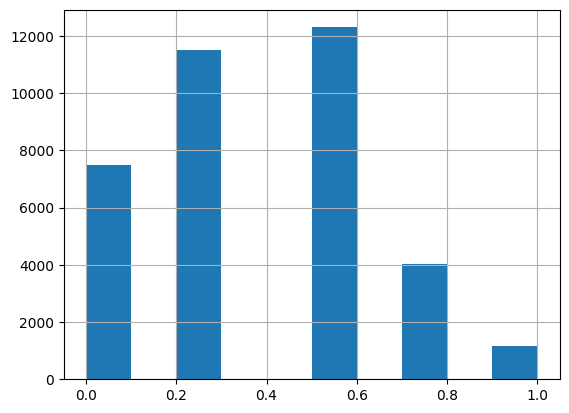

In [8]:
# look at score (the DV)
df.score.hist();

### Preprocess

#### Download tokenizer

In [9]:
# choose model for tokenizer (tokenizer is model specific)
model_name = 'microsoft/deberta-v3-small'

tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer

DebertaV2TokenizerFast(name_or_path='microsoft/deberta-v3-small', vocab_size=128000, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '[CLS]', 'eos_token': '[SEP]', 'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	3: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	128000: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}

In [10]:
# start of a new word is represented by '▁'
# uncommon word sare split into pieces
tokenizer.tokenize("A platypus is an ornithorhynchus anatinus.")

['▁A',
 '▁platypus',
 '▁is',
 '▁an',
 '▁or',
 'ni',
 'tho',
 'rhynch',
 'us',
 '▁an',
 'at',
 'inus',
 '.']

In [11]:
# look at the vocab (from the tokenizer) -- contains a unique integer for every possible token string
print(tokenizer.vocab['▁is'])
print(tokenizer.vocab['is'])

269
1890


In [13]:
# special tokens
tokenizer.all_special_tokens

['[CLS]', '[SEP]', '[UNK]', '[PAD]', '[MASK]']

#### Combine multiple text columns together

In [14]:
sep = tokenizer.sep_token
sep

'[SEP]'

In [15]:
# add a column that will be the input of the model
df['inputs'] = df.context + sep + df.anchor + sep + df.target
df.head(3)

,id,anchor,target,context,score,inputs
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50,A47[SEP]abatement[SEP]abatement of pollution
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75,A47[SEP]abatement[SEP]act of abating
2,36d72442aefd8232,abatement,active catalyst,A47,0.25,A47[SEP]abatement[SEP]active catalyst


In [16]:
# an alternative way to do this
df['tmp'] = 'TEXT1: ' + df.context + '; TEXT2: ' + df.target + '; ANC1: ' + df.anchor
df.head(3)

,id,anchor,target,context,score,inputs,tmp
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50,A47[SEP]abatement[SEP]abatement of pollution,TEXT1: A47; TEXT2: abatement of pollution; ANC...
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75,A47[SEP]abatement[SEP]act of abating,TEXT1: A47; TEXT2: act of abating; ANC1: abate...
2,36d72442aefd8232,abatement,active catalyst,A47,0.25,A47[SEP]abatement[SEP]active catalyst,TEXT1: A47; TEXT2: active catalyst; ANC1: abat...


#### Create train/validation datasets

In [17]:
# transformers uses a dataset object
ds = Dataset.from_pandas(df)
ds

Dataset({
    features: ['id', 'anchor', 'target', 'context', 'score', 'inputs', 'tmp'],
    num_rows: 36473
})

In [18]:
# transforms always assumes the DV is "labels"
ds = ds.rename_columns({'score':'labels'})
ds

Dataset({
    features: ['id', 'anchor', 'target', 'context', 'labels', 'inputs', 'tmp'],
    num_rows: 36473
})

#### Tokenize data

In [19]:
def tok_func(x):
  """
  Tokenize the inputs
  """
  tokenized = tokenizer(x["inputs"])
  return tokenized

In [20]:
# tokenize a single input
# we only care about input_ids right now
tok_func(ds[0])

{'input_ids': [1, 336, 5753, 2, 47284, 2, 47284, 265, 6435, 2], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [21]:
# tokenize every row in the dataset -- adds a new item to ds called "input_ids"
# also, remove columns you don't need
inps = "anchor","target","context","id"
tok_ds = ds.map(tok_func, batched=True, remove_columns=inps) # map makes it run in parallel
tok_ds

Map:   0%|          | 0/36473 [00:00<?, ? examples/s]

Dataset({
    features: ['labels', 'inputs', 'tmp', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 36473
})

In [22]:
# single item of the ds
item = tok_ds[0]
item

{'labels': 0.5,
 'inputs': 'A47[SEP]abatement[SEP]abatement of pollution',
 'tmp': 'TEXT1: A47; TEXT2: abatement of pollution; ANC1: abatement',
 'input_ids': [1, 336, 5753, 2, 47284, 2, 47284, 265, 6435, 2],
 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

#### Create validation set

In [23]:
# Randomly shuffle anchors
anchors = df.anchor.unique()
np.random.seed(42)
np.random.shuffle(anchors)
anchors[:5]

array(['time digital signal', 'antiatherosclerotic', 'filled interior',
       'dispersed powder', 'locking formation'], dtype=object)

In [24]:
# pick a proportion of anchors to go in the validation set
val_prop = 0.25
val_sz = int(len(anchors)*val_prop)
val_anchors = anchors[:val_sz]
val_anchors[:10]

array(['time digital signal', 'antiatherosclerotic', 'filled interior',
       'dispersed powder', 'locking formation', 'container opener',
       'apply to anode electrode', 'pen based computer', 'running tally',
       'maleic anhydride grafted'], dtype=object)

In [25]:
# get a list of which rows match val_anchors, and get their indices
is_val = np.isin(df.anchor, val_anchors)
idxs = np.arange(len(df))
val_idxs = idxs[ is_val]
trn_idxs = idxs[~is_val]
len(val_idxs),len(trn_idxs)

(9116, 27357)

In [26]:
# compare means
df.iloc[trn_idxs].score.mean(),df.iloc[val_idxs].score.mean()

(0.3623021530138539, 0.3613426941641071)

In [27]:
# Transformers uses a `DatasetDict` for holding your training and validation sets
# note: the validation set in this dds needs to be called "test set", which is annoying
dds = DatasetDict({
  "train":tok_ds.select(trn_idxs),
  "test": tok_ds.select(val_idxs)
})
dds

DatasetDict({
    train: Dataset({
        features: ['labels', 'inputs', 'tmp', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 27357
    })
    test: Dataset({
        features: ['labels', 'inputs', 'tmp', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 9116
    })
})

In [28]:
# easier way to do this
dds = tok_ds.train_test_split(0.25, seed=42)
dds

DatasetDict({
    train: Dataset({
        features: ['labels', 'inputs', 'tmp', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 27354
    })
    test: Dataset({
        features: ['labels', 'inputs', 'tmp', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 9119
    })
})

#### Create test set

In [29]:
# test set
eval_df = pd.read_csv(path/'test.csv')
eval_df['inputs'] = eval_df.context + sep + eval_df.anchor + sep + eval_df.target
eval_ds = Dataset.from_pandas(eval_df).map(tok_func, batched=True)
eval_ds

Map:   0%|          | 0/36 [00:00<?, ? examples/s]

Dataset({
    features: ['id', 'anchor', 'target', 'context', 'inputs', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 36
})

## Train transformers model
- Transformers works well with "sequence-to-sequence" problems (where the dependent variable is itself a variable-length sequence, such as language translation)
- They are also very good at capturing long-range dependencies and reltationships in data
- Here, we are first just running through all of the code to get a big picture


### Evaluation metric -- correlation

In [30]:
# we need to return a dictionary since that's how Transformers know what label to use
def corr(eval_pred):
  return{'pearson': np.corrcoef(*eval_pred)[0][1]}

In [31]:
# hyperparams
bs = 128
epochs = 4
lr = 8e-5
wd = 0.01

In [32]:
# Transformers use the TrainingArguments class to set up arguments
# needs to be run on a gpu
args = TrainingArguments(
  'outputs',
  learning_rate=lr,
  warmup_ratio=0.1,
  lr_scheduler_type='cosine',  # cosine scheduler (with warmup)
  fp16=True,
  evaluation_strategy="epoch",
  per_device_train_batch_size=bs,
  per_device_eval_batch_size=bs*2, # evaluate using double-sized batches, since no gradients are stored so we can do twice as many rows at a time
  num_train_epochs=epochs,
  weight_decay=wd,
  report_to='none'
)
# args

In [33]:
# crate model
# recall, model name was specified earlier -- used for tokenization
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=1)
model

pytorch_model.bin:   0%|          | 0.00/286M [00:00<?, ?B/s]

DebertaV2ForSequenceClassification(
  (deberta): DebertaV2Model(
    (embeddings): DebertaV2Embeddings(
      (word_embeddings): Embedding(128100, 768, padding_idx=0)
      (LayerNorm): LayerNorm((768,), eps=1e-07, elementwise_affine=True)
      (dropout): StableDropout()
    )
    (encoder): DebertaV2Encoder(
      (layer): ModuleList(
        (0-5): 6 x DebertaV2Layer(
          (attention): DebertaV2Attention(
            (self): DisentangledSelfAttention(
              (query_proj): Linear(in_features=768, out_features=768, bias=True)
              (key_proj): Linear(in_features=768, out_features=768, bias=True)
              (value_proj): Linear(in_features=768, out_features=768, bias=True)
              (pos_dropout): StableDropout()
              (dropout): StableDropout()
            )
            (output): DebertaV2SelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-07, elementwise_affine=T

In [34]:
# create trainer (class that combines the data and model together)
# like learner in fastai
trainer = Trainer(
  model,
  args,
  train_dataset=dds['train'],
  eval_dataset=dds['test'], # validation set
  tokenizer=tokenizer, # defined above
  compute_metrics=corr # we defined this above
)
trainer

In [35]:
# train model
# look for pearson correlation (our evaluation metric)
trainer.train();

Epoch,Training Loss,Validation Loss,Pearson
1,No log,0.030799,0.794244
2,No log,0.022934,0.814307
3,0.043000,0.022468,0.828692
4,0.043000,0.022996,0.829272


In [36]:
# get preds
preds = trainer.predict(eval_ds).predictions.astype(float)

# fix out of bounds predictions (<0 or >1)
preds = np.clip(preds, 0, 1)
preds[:5]

array([[0.57763672],
       [0.62646484],
       [0.51757812],
       [0.31787109],
       [0.        ]])

In [37]:
# save
submission = datasets.Dataset.from_dict({
  'id': eval_ds['id'],
  'score': preds
})

submission.to_csv('submission.csv', index=False)

Creating CSV from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

1025

### Iterate
- Need to know whether the model gives stable results (e.g., try training it 3 times from scratch)
- Later on, if and when we feel confident that we've got the basics right, we can use cross validation and more epochs of training.

In [38]:
# function to apply tokenization and create the dataset dict
# note -- requires the train/valid indices we created by hand earlier
def get_dds(df):
  ds = Dataset.from_pandas(df).rename_column('score', 'label')
  tok_ds = ds.map(
    tok_func,
    batched=True,
    remove_columns=inps+('inputs','id')
  )

  dds = DatasetDict({
    "train":tok_ds.select(trn_idxs),
    "test": tok_ds.select(val_idxs)
  })
  return dds

In [39]:
# function to create a trainer
def get_model():
  return AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=1)

def get_trainer(dds, model=None):
  if model is None:
    model = get_model()

  args = TrainingArguments(
    'outputs',
    learning_rate=lr,
    warmup_ratio=0.1,
    lr_scheduler_type='cosine',
    fp16=True,
    evaluation_strategy="epoch",
    per_device_train_batch_size=bs,
    per_device_eval_batch_size=bs*2,
    num_train_epochs=epochs,
    weight_decay=wd,
    report_to='none'
  )

  trainer = Trainer(
    model,
    args,
    train_dataset=dds['train'],
    eval_dataset=dds['test'],
    tokenizer=tokenizer,
    compute_metrics=corr
  )
  return trainer

#### Try a different separater

In [40]:
sep = " [s] "
df['inputs'] = df.context + sep + df.anchor + sep + df.target

dds = get_dds(df)
get_trainer(dds).train()

Map:   0%|          | 0/36473 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss,Pearson
1,No log,0.024950,0.801454
2,No log,0.026331,0.815467
3,0.029700,0.023691,0.818883
4,0.029700,0.024160,0.819522


TrainOutput(global_step=856, training_loss=0.02278392504308825, metrics={'train_runtime': 192.8065, 'train_samples_per_second': 567.553, 'train_steps_per_second': 4.44, 'total_flos': 582121520370810.0, 'train_loss': 0.02278392504308825, 'epoch': 4.0})

#### Try lowercase

In [41]:
df['inputs'] = df.inputs.str.lower()
dds = get_dds(df)
get_trainer(dds).train()

Map:   0%|          | 0/36473 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss,Pearson
1,No log,0.026600,0.796815
2,No log,0.026546,0.817279
3,0.031300,0.023419,0.817951
4,0.031300,0.024410,0.818169


TrainOutput(global_step=856, training_loss=0.023865558833719415, metrics={'train_runtime': 194.9328, 'train_samples_per_second': 561.363, 'train_steps_per_second': 4.391, 'total_flos': 582121520370810.0, 'train_loss': 0.023865558833719415, 'epoch': 4.0})

#### Make the patent section a special token
So that different sections need to be handled in different ways

**_Note_: `section` isn't in the df. not sure why. I've commented this section out because we can't run it, but kept it in here for reference for other projects**

In [42]:
# # turn patent sections into special tokens (e.g., Section A --> [A])
# df['sectok'] = '[' + df.section + ']'
# sectoks = list(df.sectok.unique())
# tokenizer.add_special_tokens({'additional_special_tokens': sectoks})

In [43]:
# # add the section token to the start of the inputs
# df['inputs'] = df.sectok + sep + df.context + sep + df.anchor.str.lower() + sep + df.target
# dds = get_dds(df)

In [44]:
# # Since we've added more tokens, we need to resize the embedding matrix in the model
# model = get_model()
# model.resize_token_embeddings(len(tokenizer))

In [45]:
# # train
# trainer = get_trainer(dds, model=model)
# trainer.train()

### Cross-validation
- 4 folds = 4 models and 4 sets of predictions and metrics
- can ensemble the 4 models to get a stronger model
- can also average the 4 metrics to get a more accurate assessment of your model

In [46]:
from sklearn.model_selection import StratifiedGroupKFold

n_folds = 4
cv = StratifiedGroupKFold(n_splits=n_folds)

In [47]:
# randomly shuffle the rows
df = df.sample(frac=1, random_state=42)

In [48]:
# split the data frame into n_folds groups, with non-overlapping anchors and matched scores
scores = (df.score*100).astype(int)
folds = list(cv.split(idxs, scores, df.anchor))
folds

[(array([    0,     1,     2, ..., 36469, 36471, 36472]),
  array([    8,    13,    14, ..., 36453, 36464, 36470])),
 (array([    0,     1,     5, ..., 36470, 36471, 36472]),
  array([    2,     3,     4, ..., 36459, 36461, 36462])),
 (array([    1,     2,     3, ..., 36467, 36470, 36472]),
  array([    0,     7,    11, ..., 36468, 36469, 36471])),
 (array([    0,     2,     3, ..., 36469, 36470, 36471]),
  array([    1,     5,     9, ..., 36465, 36467, 36472]))]

In [49]:
# split into train/valid sets based on a fold
def get_fold(folds, fold_num):
  trn,val = folds[fold_num]
  return DatasetDict({"train":tok_ds.select(trn), "test": tok_ds.select(val)})

In [50]:
# get dds
dds = get_fold(folds, 0)
dds

DatasetDict({
    train: Dataset({
        features: ['labels', 'inputs', 'tmp', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 27346
    })
    test: Dataset({
        features: ['labels', 'inputs', 'tmp', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 9127
    })
})

In [51]:
# get the final epoch metrics from a trainer
metrics = [o['eval_pearson'] for o in trainer.state.log_history if 'eval_pearson' in o]
print(metrics)

# final metric
metrics[-1]

[0.7942444538888033, 0.8143074177887484, 0.8286924799565081, 0.8292720857935653]


0.8292720857935653

# Part 2. ChatGPT's descriptions of transformers
I've annotated the code in detail.

**Note! There may be errors in the code because ChatGPT is NOT perfect!**

### Terminology
- Attention Head
  - An "attention head" refers to an individual stream or pathway through which the model processes information
  - Each attention head independently learns different relationships and patterns within the input sequence.
  - By having multiple attention heads, the model can capture diverse features and relationships simultaneously.
  - For each attention head, the input embeddings are linearly transformed into three sets of vectors: queries, keys, and values. These vectors play distinct roles in the self-attention mechanism
- Query
  - The query is a linear transformation applied to the input embeddings to create a set of query vectors.
  - These query vectors are used to determine how much attention each element in the sequence should pay to other elements.
  - Queries represent the elements of the input sequence for which the model is trying to find relevant information or relationships.
  - For each element in the input sequence, a corresponding query vector is created.
  - Mathematically, if X is the input sequence, the query vectors Q are computed as Q = X * W_q, where W_q is a learnable weight matrix.
- Key
  - Similar to the query, the key is another linear transformation applied to the input embeddings to create a set of key vectors.
  - These key vectors represent the elements that the query vectors will attend to.
  - Keys represent the elements of the input sequence that provide context or information about other elements in the sequence.
  - For each element in the input sequence, a corresponding key vector is created.
  - Mathematically, if X is the input sequence, the key vectors K are computed as K = X * W_k, where W_k is a learnable weight matrix.
- Value
  - The value is a linear transformation applied to the input embeddings to create a set of value vectors.
  0 These value vectors represent the information that will be combined based on the attention weights obtained from the query-key interactions.
  - Values represent the actual information associated with each element in the input sequence.
  - For each element in the input sequence, a corresponding value vector is created.
  - Mathematically, if X is the input sequence, the value vectors V are computed as V = X * W_v, where W_v is a learnable weight matrix.

### Self-Attention Mechanism
- The core of the transformer architecture is the self-attention mechanism. This mechanism allows the model to weigh the importance of different parts of the input sequence when processing each element. It lets the transformer model focus on (and amplify) the signal from the relevant parts of the input
- For each element in the input sequence, attention scores are calculated with respect to all other elements. These scores determine how much focus should be given to each element during computation. should be given to each element during computation.
- In the self-attention mechanism, the interactions between queries, keys, and values are computed using dot products. The attention scores are calculated by taking the dot product of queries with keys, and the weighted sum of values based on these attention scores provides the output of the attention mechanism.



In [52]:
import torch
import torch.nn as nn

In [53]:
class SelfAttention(nn.Module):
  def __init__(self, embed_size, heads):
    super(SelfAttention, self).__init__()
    self.embed_size = embed_size # dimensionality of the input embeddings (e.g., 256)
    self.heads = heads # number of attention heads (e.g., 8)
    self.head_dim = embed_size // heads # dimensionality of each attention head (e.g., 32: each attention head processes information in a 32 dimensional space)

    assert ( # throws error if head_dim isn't an integer
      self.head_dim * heads == embed_size
    ), "Embedding size needs to be divisible by heads"

    # Linear transformations for values, keys, and queries (involves learned weights)
    self.values = nn.Linear(self.head_dim, self.head_dim, bias=False) # Provides the information associated with each element in the sequence
    self.keys = nn.Linear(self.head_dim, self.head_dim, bias=False) # Represents the elements to which the query vectors will attend
    self.queries = nn.Linear(self.head_dim, self.head_dim, bias=False) # Determines what to focus on in the input sequence

    # Linear transformation for the output of self-attention
    self.fc_out = nn.Linear(
        heads * self.head_dim, # the combined size of the output vectors from all attention heads
        embed_size # desired dimensionality of the output after the linear transformation
      )

  def forward(self, values, keys, query, mask):
    # Get number of training examples
    N = query.shape[0] # the number of the training samples in the batch

    # Calculate the lengths of the sequences for v,k,q.
    # Each sequence can have a different length
    value_len, key_len, query_len = values.shape[1], keys.shape[1], query.shape[1]

    # Split the embedding into self.heads different pieces
    # Reshaping is done to split the embedding vectors into different pieces corresponding to each attention head
    values = values.reshape(N, value_len, self.heads, self.head_dim)
    keys = keys.reshape(N, key_len, self.heads, self.head_dim)
    queries = query.reshape(N, query_len, self.heads, self.head_dim)

    # Linear transformations for values, keys, and queries (involves weights and biases)
    # Project v,k,q into a new space with different dimensions
    values = self.values(values) # self.values is actual an instance of nn.Linear
    keys = self.keys(keys) # same as above: this is a linear transformation
    queries = self.queries(queries) # same

    # Calculate attention scores using the self-attention mechanism
    # Attention scores = weights assigned to different positions in the input sequence (similarity between keys and values)
    # Uses batched matrix multiplication and summation of queries and keys
    # This is shown with Einstein summation notation, which specifies the dimensions and operations
    # The resulting tensor (energy) has dimensions (N, heads, query_len, key_len)
    energy = torch.einsum(
      "nqhd,nkhd->nhqk",
        # nqhd: shape of the queries tensor = (batch_size, query_len, heads, head_dim)
        # nkhd: shape of the keys tensor = (batch_size, key_len, heads, head_dim)
        # -> the operation to be performed (batched matrix multiplication and summation)
        # nhqk: shape of the resulting tensor = (batch_size, heads, query_len, key_len)
      [queries, keys]
    )

    # optional mask: used to zero out certain elements in the attention scores based on the mask's values
    # If a mask is provided, use masked_fill to replace elements in the energy tensor
    # with a large negative value (float("-1e20")) where the corresponding mask value is 0
    # By setting the attention scores to a large negative value, the softmax operation later
    # in the process ensures that the attention weights for those positions become close to zero
    if mask is not None:
      energy = energy.masked_fill(mask == 0, float("-1e20"))

    # Apply softmax to obtain attention weights
    # The attention scores calculated from the energy tensor are normalized using the softmax function
    attention = torch.nn.functional.softmax(
      energy / (self.embed_size ** (1 / 2)), # scales the energy tensor by the square root of the embedding size (stabilizes gradients)
      dim=3 # apply softmax along the 4th dimension of the scaled energy tensor (the key sequence length)
    )

    # Apply attention weights to values and reshape
    # Calculates attended values = result of applying attention scores to the values (linearly combined)
    out = torch.einsum(
      "nhql,nlhd->nqhd",
        # nhql: shape of the attention tensor = (batch_size, heads, query_len, key_len)
        # nlhd: shape of the values tensor = (batch_size, key_len, heads, head_dim)
        # nqhd: shape of the resulting tensor = (batch_size, query_len, heads, head_dim)
      [attention, values]
    ).reshape(
      N, query_len, self.heads * self.head_dim # combines the dimensions of the attention heads to (batch_size, query_len, heads * head_dim)
    )

    # Linear transformation for the output of self-attention
    # Maps the output of the self-attention mechanism to a new space with a different dimensionality specified by embed_size
    # final output shape: (batch_size, query_len, embed_size)
    out = self.fc_out(out) # self.hc_out is an instance of the nn.Linear module

    return out

### Multi-Head Attention
- To enhance the model's ability to capture diverse patterns, transformers use multiple self-attention mechanisms in parallel, known as "multi-head attention."
- Each attention head learns different relationships and representations. The outputs from all attention heads are concatenated and linearly transformed to obtain the final attention output.
- Note: it operates with multiple heads in parallel. Each head has its own set of learned parameters. At the end of the class, the outputs of the heads are concatenated.

In [54]:
class MultiHeadAttention(nn.Module):
  def __init__(self, embed_size, heads):
    super(MultiHeadAttention, self).__init__()
    self.embed_size = embed_size # embeddings dimensions
    self.heads = heads # number of attention heads
    self.head_dim = embed_size // heads # dimensionality of attention heads

    assert (
        self.head_dim * heads == embed_size
    ), "Embedding size needs to be divisible by heads" # throw error if head_dim isn't an integer

    # Instantiate self-attention mechanism (defined above) --> combination of attention scores and attended values
    # SelfAttention created a single attention head
    # Now we can use multiple instances of this block to create a multi-headed attention mechanism
    self.attention = SelfAttention(embed_size, heads) # there are heads instances of SelfAttention, each with its own learned params

    # Linear transformation for the output of multi-head attention
    self.fc_out = nn.Linear(
      heads * self.head_dim, # input size
      embed_size # oupput size
    )

  def forward(self, values, keys, query, mask):
    N = query.shape[0] # the number of the training samples in the batch
    value_len, key_len, query_len = values.shape[1], keys.shape[1], query.shape[1] #  Calculate the lengths of the sequences for v,k,q

    # Split the embedding into self.heads different pieces
    values = values.reshape(N, value_len, self.heads, self.head_dim)
    keys = keys.reshape(N, key_len, self.heads, self.head_dim)
    queries = query.reshape(N, query_len, self.heads, self.head_dim)

    # Transpose dimensions for compatibility with self-attention mechanism
    values = values.permute(0, 2, 1, 3) # original dimensions: (batch_size, value_len, heads, head_dim); new dimensions: (batch_size, heads, value_len, head_dim)
    keys = keys.permute(0, 2, 1, 3) # orig: (batch_size, key_len, heads, head_dim); new: (batch_size, heads, key_len, head_dim)
    queries = queries.permute(0, 2, 1, 3) # orig: (batch_size, query_len, heads, head_dim); new: (batch_size, heads, query_len, head_dim)

    # Apply multi-head attention mechanism to the input tensors v,k,q
    attention = self.attention(values, keys, queries, mask) # attention dimensions: (batch_size, heads, query_len, key_len)

    # Transpose dimensions back (contiguous has to do with the memory layout)
    attention = attention.permute(0, 2, 1, 3).contiguous() # new attention dimensions: (batch_size, query_len, heads, key_len)

    # Reshape to match the input dimensions
    # concatenates the outputs of the individual attention heads
    out = attention.reshape(N, query_len, self.heads * self.head_dim) # concatenates along the embedding dimension

    # Linear transformation for the output of multi-head attention
    return self.fc_out(out)

### Positional Encoding
- Transformers don't have an inherent understanding of the order of elements in a sequence. To incorporate sequential information, positional encodings are added to the input embeddings.
- Positional encodings are vectors that represent the position of each element in the sequence, allowing the model to distinguish between different positions.
- Notes:
  - The use of alternating columns (sine for even-indexed columns and cosine for odd-indexed columns) in the positional encoding helps introduce distinct patterns in the encoding for different positions along the sequence. This alternating pattern helps capture different frequencies of positional information.
  - Sine and cosine functions have different frequencies. By using them alternately, you introduce a mix of high-frequency (sine) and low-frequency (cosine)components into the positional encoding.
  - The alternating pattern allows the model to capture different aspects of positional information. For example, the model can learn to associate even-indexed columns (sine) with fine-grained details or rapid changes in position, while odd-indexed columns (cosine) may be associated with broader trends or slower changes.
  - Using sine and cosine functions in alternating columns also creates an orthogonal encoding. This orthogonality helps ensure that different positional embeddings are not highly correlated, allowing the model to better distinguish between different positions in the sequence.

In [55]:
class PositionalEncoding(nn.Module):
  def __init__(self, d_model, max_len=512):
    super(PositionalEncoding, self).__init__()

    # Initialize positional encodings tensor with all 0s
    self.encoding = torch.zeros(
      max_len, # maximum length of sequences that the positional encoding will be applied to
      d_model # dimensionality of the input embeddings (embedding space), e.g., 256
    )

    # Create a tensor position containing values from 0 to max_len - 1.
    position = torch.arange(0, max_len).unsqueeze(1).float() # unsqueeze(1) adds a new dimension to make it a column vector

    # Generates a tensor div_term containing exponential values
    # It involves using exponential and logarithmic operations to create a set of values that will be used in the positional encoding formula
    # The div_term tensor contains values that will be used in the positional encoding formula to introduce varying frequencies of positional information
    div_term = torch.exp( # Computes the exponential function (base e) element-wise on the tensor resulting from the below operations.
      torch.arange(
        0, d_model, # 2 Generates a 1-dimensional tensor containing values from 0 to d_model - 2 with a step size of 2.
      ).float() * -( # negative sign is applied because the values will be used with the torch.exp function, and the exponential of a negative value is the reciprocal of the exponential of the positive value.
        torch.log(torch.tensor(10000.0)) # Calculates the natural logarithm of 10000.0
        / d_model # Divides the logarithm by d_model, and negates the result (- above)
      )
    )

    # Calculate sinusoidal positional encoding
    self.encoding[:, 0::2] = torch.sin(position * div_term) # computes the sine of the product of position and div_term for elements in even-indexed columns
    self.encoding[:, 1::2] = torch.cos(position * div_term) # cosine of the product of position and div_term for elements in odd-indexed column
    self.encoding = self.encoding.unsqueeze(0)  # After calculating sine and cosine values for alternating columns, the entire tensor gets a new dimension at the beginning so it has shape: (1, max_len, d_model)

  def forward(self, x):
    # Add positional encoding to the input tensor (x)
    # self.encoding[:, : x.size(1)] = tensor containing positional encoding values for each position in the sequence up to the length of the input x
    return x + self.encoding[:, : x.size(1)].detach() # detach means create a copy without gradients

### Encoder and Decoder Stacks
- Transformers consist of multiple layers of encoders and decoders. The encoder processes the input sequence, while the decoder generates the output sequence.
- Each layer in the encoder and decoder contains a self-attention mechanism and feedforward neural network, enabling the model to learn hierarchical representations.
- Encoder perspective
  - SelfAttention and MultiHeadAttention: These components contribute to the encoder's self-attention mechanism. In the context of the encoder, the attention mechanism allows each position in the input sequence to focus on relevant positions within the same sequence.
  - PositionalEncoding: It adds positional information to the input embeddings. In the encoder, this helps the model consider the order of the input sequence, as transformers do not inherently understand the order of tokens.
  - TransformerBlock: Represents a single block in the encoder stack. It typically includes self-attention, normalization, feedforward processing, and skip connections. When stacked, multiple TransformerBlock instances create the encoder layers.
- Decoder perspective
  - Decoders do things such as handling the end token, maintaining hidden states across time steps, etc.
- The encoder and decoder architectures are often instantiated separately and then combined. The decoder usually includes an additional attention mechanism that attends to the encoder's output.

In [56]:
class TransformerBlock(nn.Module):
  def __init__(self, embed_size, heads):
    super(TransformerBlock, self).__init__()

    # Instantiate multi-head attention mechanism
    self.attention = MultiHeadAttention(embed_size, heads)

    # Feedforward neural network
    self.feedforward = nn.Sequential(
      nn.Linear(embed_size, 4 * embed_size), # input = embed_size; output = 4*embed_size
      nn.ReLU(), # introduce non-linearity
      nn.Linear(4 * embed_size, embed_size), # output = embed_size
    )

    # Layer normalization
    # normalizes values across the feature dimension (along each feature or channel)
    # independently for each example in the batch
    # helps stabilize training by reducing the internal covariate shift
    # which is from the change in the distribution of network activtions due to parameter updates during training
    self.norm1 = nn.LayerNorm(embed_size) # normalize outputs of self-attention
    self.norm2 = nn.LayerNorm(embed_size) # normalizeoutputs of the feedforward NN

    # Dropout for regularization
    # sets a fraction of input units to 0 during training
    # helps with overfitting
    self.dropout = nn.Dropout(0.1) # dropout rate = 0.1

  def forward(self, value, key, query, mask):
    # Apply multi-head attention
    # output 'attention' = (batch_size, query_len, self.heads*self.head_dim)
    attention = self.attention(value, key, query, mask)

    # Add skip connection (aka residual connection)
    # attention + query = skip connection
    # allows the model to retain information from the original input instead of only the output
    # skip connections address the vanishing gradient problem during training (lets you train deeper networks)
    # also facilitates the learning of identity mappings (allowing network to learn to only make necessary modifications to the input)
    x = self.norm1( # normalize the folowing
      attention + # attention tensor
      query # original input tensor
    ) # the element-wise addition creates a shortcut connection that directly passes the original input info to the next layer
    x = self.dropout(x) # apply dropout

    # Feedforward (2 linears layers with ReLU in between)
    forward = self.feedforward(x)

    # Add another skip connection, this time to the output from the feedforward NN
    out = self.norm2(forward + x) # normalize the result of the skip connection
    out = self.dropout(out) # apply dropout
    return out # dimensions = (batch_size, query_len, embed_size)

In [57]:
class DecoderBlock(nn.Module):
  def __init__(self, embed_size, heads):
    super(DecoderBlock, self).__init__()

    # Self Attention block -- dependencies within the target sequence
    # Handle the self-attention mechanism within the decoder block
    # Allows the decoder to attend to different positions within the target sequence
    self.self_attention = MultiHeadAttention(embed_size, heads)

    # Encoder-Decoder Attention block -- incorporates ino from the sourcesequence into the decoding process
    # Used for attenting to the encoder's output from the source sequence
    # Lets the decoder consider relevant information from the source sequence while generating the target sequence
    # The attention scores are calculated based on the relationship between the target and source sequences
    self.encoder_attention = MultiHeadAttention(embed_size, heads)

    # Typical FF Network
    self.feedforward = nn.Sequential(
      nn.Linear(embed_size, 4 * embed_size), # feature expansion (4 times)
      nn.ReLU(),
      nn.Linear(4 * embed_size, embed_size), # go back to original dimensions
    )

    # Normalization and dropout
    self.norm1 = nn.LayerNorm(embed_size) # normalize output of self-attention mechanism
    self.norm2 = nn.LayerNorm(embed_size) # normalize output of the first skip connection
    self.norm3 = nn.LayerNorm(embed_size) # normalize output of the second skip connection
    self.dropout = nn.Dropout(0.1) # dropout

  def forward(self, target, source, target_mask, source_mask):
    # Self-Attention Block
    # Apply multi-headed self attention to compute attention scores, apply softmax, produce attention-weighted output
    # Apply dropout to the attention output, add skip connection, and normalize
    attention_output = self.self_attention(target, target, target, target_mask) # targets = q,k,v, plus optional mask
    x = self.norm1(target + self.dropout(attention_output))

    # Encoder-Decoder Attention Block

    # Apply multi-headed self attention to compute attention scores between the current decoder state (x) and the encoder outputs (source) using the provided mask
    # Apply dropout to the output, add skip connection, and normalize
    encoder_attention_output = self.encoder_attention(x, source, source, source_mask) # x = queries from decoder block; source = keys and values; source_mask = optional
    x = self.norm2(x + self.dropout(encoder_attention_output))

    # Feedforward Block
    forward_output = self.feedforward(x) # linear layer, ReLU, linear layer
    x = self.norm3(x + self.dropout(forward_output)) # apply drpout, add skip connection, normalize

    return x

In [58]:
class TransformerDecoder(nn.Module):
  def __init__(self, embed_size, heads, num_layers):
    super(TransformerDecoder, self).__init__()

    # nn.ModuleList = container model that holds multiple instances of DecoderBlock
    self.decoder_blocks = nn.ModuleList([
      DecoderBlock(embed_size, heads) # for each iteration, a new DecoderBlock is created
      for _ in range(num_layers) # run num_layers times
    ])

  def forward(self, target, source, target_mask, source_mask):
    # By applying each DecoderBlock successively,
    # it allows the input sequence to undergo multiple transformations,
    # capturing complex dependencies and patterns in the decoding process
    for decoder_block in self.decoder_blocks:
      # for each iteration, the target sequence is updated as it passes through the DecoderBlock
      target = decoder_block( # perform self-attention, FF processing, normalization
        target, # input sequence to the decoder
        source, # source sequence or encoder output
        target_mask, # mask certain positions, e.g., helps prevent attending to  future positions in the target sequence during trainging
        source_mask # mask certain positions
      )
    return target

### Feedforward Networks
- Transformers include feedforward neural networks within each layer to further capture complex patterns and relationships.

In [59]:
class FeedForward(nn.Module):
  def __init__(self, d_model, d_ff, dropout=0.1):
    super(FeedForward, self).__init__()

    # Two linear layers with ReLU activation in between
    self.linear1 = nn.Linear(
      d_model, # input dimensionality of the FF NN
      d_ff # hidden dimensionality of the FF NN
    )
    self.dropout = nn.Dropout(dropout)
    self.relu = nn.ReLU()
    self.linear2 = nn.Linear(d_ff, d_model) # go back to input dimensionality

  def forward(self, x):
    # Apply feedforward neural network
    x = self.linear1(x)
    x = self.relu(x)
    x = self.dropout(x)
    x = self.linear2(x)
    return x

### Normalization and Residual Connections
- Layer normalization and residual connections are used to stabilize and speed up training. Residual connections enable the model to directly learn the residual (difference) between the input and output of a layer.

In [60]:
class AddNorm(nn.Module):
  def __init__(self, normalized_shape, dropout=0.1):
    super(AddNorm, self).__init__()

    # Layer normalization with dropout
    self.dropout = nn.Dropout(dropout)
    self.norm = nn.LayerNorm(normalized_shape) # normalized_shape = shape of nprmalized layer (dimensionality of input embeddings or intermediate representations)

  def forward(self, x, y):
    # Usually this is done to normalize intermediate representations
    residual = x + self.dropout(y) # Add skip-connection: element-wise addition of 2 tensors (e.g., adding input tensor to the output of a sub-layer)
    return self.norm(residual) # Applies normalization to the residual independently for each example in the batch

## PyTorch's version (according to ChatGPT)
Again, there may be errors in this because ChatGPT tends to miss things.

#### Input and Target

In [61]:
# assuming we are doing a translation task
input_sequence = ["<START>", "I", "love", "transformers", "<END>"]
target_sequence = ["<START>", "J'aime", "les", "transformateurs", "<END>"]
input_sequence

['<START>', 'I', 'love', 'transformers', '<END>']

In [62]:
# preprocess
vocab = {"<PAD>": 0, "<START>": 1, "<END>": 2, "I": 3, "love": 4, "transformers": 5, "J'aime": 6, "les": 7, "transformateurs": 8}
word_to_index = {word: idx for idx, word in enumerate(vocab)}
word_to_index

{'<PAD>': 0,
 '<START>': 1,
 '<END>': 2,
 'I': 3,
 'love': 4,
 'transformers': 5,
 "J'aime": 6,
 'les': 7,
 'transformateurs': 8}

In [63]:
# Convert input_sequence and target_sequence to numeric indices
input_sequence_numeric = [word_to_index[word] for word in input_sequence]
target_sequence_numeric = [word_to_index[word] for word in target_sequence]
input_sequence_numeric

[1, 3, 4, 5, 2]

In [64]:
# Define word embeddings
embedding_dim = 8
embedding = nn.Embedding(len(vocab), embedding_dim)
embedding

Embedding(9, 8)

In [65]:
# Convert numeric indices to embeddings
input_sequence_embeddings = embedding(torch.tensor(input_sequence_numeric))
target_sequence_embeddings = embedding(torch.tensor(target_sequence_numeric))
input_sequence_embeddings

tensor([[-0.3097, -0.3957,  0.8034, -0.6216, -0.5920, -0.0631, -0.8286,  0.3309],
        [-1.4181,  0.8963,  0.0499,  2.2667,  1.1790, -0.4345, -1.3864, -1.2862],
        [-0.8371, -0.9224,  1.8113,  0.1606,  0.3672,  0.1754,  1.3852, -0.4459],
        [-1.2024,  0.7078, -1.0759,  0.5357,  1.1754,  0.5612, -0.4527, -0.7718],
        [ 0.0349,  0.3211,  1.5736, -0.8455,  1.3123,  0.6872, -1.0892, -0.3553]],
       grad_fn=<EmbeddingBackward0>)

In [66]:
# Transpose to get the desired dimensions (seq_len, batch_size, embedding_dim)
input_sequence_embeddings = input_sequence_embeddings.unsqueeze(1).transpose(0, 1)
target_sequence_embeddings = target_sequence_embeddings.unsqueeze(1).transpose(0, 1)
input_sequence_embeddings

tensor([[[-0.3097, -0.3957,  0.8034, -0.6216, -0.5920, -0.0631, -0.8286,
           0.3309],
         [-1.4181,  0.8963,  0.0499,  2.2667,  1.1790, -0.4345, -1.3864,
          -1.2862],
         [-0.8371, -0.9224,  1.8113,  0.1606,  0.3672,  0.1754,  1.3852,
          -0.4459],
         [-1.2024,  0.7078, -1.0759,  0.5357,  1.1754,  0.5612, -0.4527,
          -0.7718],
         [ 0.0349,  0.3211,  1.5736, -0.8455,  1.3123,  0.6872, -1.0892,
          -0.3553]]], grad_fn=<TransposeBackward0>)

In [67]:
# Print the dimensions
print("Input Sequence Embeddings Dimensions:", input_sequence_embeddings.size())
print("Target Sequence Embeddings Dimensions:", target_sequence_embeddings.size())

Input Sequence Embeddings Dimensions: torch.Size([1, 5, 8])
Target Sequence Embeddings Dimensions: torch.Size([1, 5, 8])


#### Encoder

In [68]:
class TransformerEncoder(nn.Module):
  def __init__(self, input_dim, hidden_dim, num_layers, num_heads):
    super(TransformerEncoder, self).__init__()

    # Positional Encoding
    self.positional_encoding = nn.Embedding(100, input_dim)  # Assuming maximum sequence length is 100

    # Transformer Encoder Layer
    encoder_layers = nn.TransformerEncoderLayer(d_model=input_dim, nhead=num_heads)
    self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers=num_layers)

  def forward(self, src):
    src = src + self.positional_encoding(torch.arange(src.size(0)).unsqueeze(1).to(src.device))
    encoder_output = self.transformer_encoder(src)
    return encoder_output

In [69]:
# positional encoding
positional_encoding = nn.Embedding(100, embedding_dim)
positional_encoding

Embedding(100, 8)

In [70]:
# encoder layers
num_heads = 4
encoder_layers = nn.TransformerEncoderLayer(d_model=embedding_dim, nhead=num_heads)
encoder_layers

TransformerEncoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=8, out_features=8, bias=True)
  )
  (linear1): Linear(in_features=8, out_features=2048, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (linear2): Linear(in_features=2048, out_features=8, bias=True)
  (norm1): LayerNorm((8,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((8,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
)

In [71]:
# complete encoder
num_layers = 2
transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers=num_layers)
transformer_encoder

TransformerEncoder(
  (layers): ModuleList(
    (0-1): 2 x TransformerEncoderLayer(
      (self_attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=8, out_features=8, bias=True)
      )
      (linear1): Linear(in_features=8, out_features=2048, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (linear2): Linear(in_features=2048, out_features=8, bias=True)
      (norm1): LayerNorm((8,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((8,), eps=1e-05, elementwise_affine=True)
      (dropout1): Dropout(p=0.1, inplace=False)
      (dropout2): Dropout(p=0.1, inplace=False)
    )
  )
)

In [72]:
# forward pass part 1
hidden_dim = 512
src = input_sequence_embeddings # for the first pass

src = src + positional_encoding(torch.arange(src.size(0)).unsqueeze(1).to(src.device))
src

tensor([[[-1.7668, -0.4980,  0.2043, -0.1445,  0.1342,  0.0281, -1.2176,
           0.8588],
         [-2.8751,  0.7939, -0.5492,  2.7438,  1.9051, -0.3433, -1.7754,
          -0.7583],
         [-2.2942, -1.0247,  1.2122,  0.6376,  1.0934,  0.2666,  0.9961,
           0.0821],
         [-2.6595,  0.6055, -1.6750,  1.0127,  1.9015,  0.6523, -0.8418,
          -0.2439],
         [-1.4221,  0.2188,  0.9744, -0.3684,  2.0385,  0.7783, -1.4782,
           0.1726]]], grad_fn=<AddBackward0>)

In [73]:
# forward pass part 2
encoder_output = transformer_encoder(src)
encoder_output

tensor([[[-2.4061,  0.7606,  0.1984,  0.2167,  1.0792, -0.3177,  0.5261,
          -0.0572],
         [-1.3867, -0.6685, -0.2469,  1.8655,  1.2047, -0.1778,  0.1694,
          -0.7598],
         [-1.9598, -0.4565,  0.8358,  0.5780,  0.2689,  1.1073,  0.6935,
          -1.0671],
         [-1.6918,  0.2978, -0.6707,  0.9531,  1.5362,  0.6629, -0.1564,
          -0.9312],
         [-1.1546,  0.8222,  0.3789, -0.1069,  1.9005, -0.5666,  0.1023,
          -1.3757]]], grad_fn=<NativeLayerNormBackward0>)

#### Decoder

In [74]:
class TransformerDecoder(nn.Module):
  def __init__(self, input_dim, hidden_dim, num_layers, num_heads):
    super(TransformerDecoder, self).__init__()

    # Positional Encoding
    self.positional_encoding = nn.Embedding(100, input_dim)  # Assuming maximum sequence length is 100

    # Transformer Decoder Layer
    decoder_layers = nn.TransformerDecoderLayer(d_model=input_dim, nhead=num_heads)
    self.transformer_decoder = nn.TransformerDecoder(decoder_layers, num_layers=num_layers)

  def forward(self, tgt, memory):
    tgt = tgt + self.positional_encoding(torch.arange(tgt.size(0)).unsqueeze(1).to(tgt.device))
    decoder_output = self.transformer_decoder(tgt, memory)
    return decoder_output

In [75]:
# same type of positional encoding as before
positional_encoding = nn.Embedding(100, embedding_dim)
positional_encoding

Embedding(100, 8)

In [76]:
# decoder layers (input_dim and num_heads were defined above)
decoder_layers = nn.TransformerDecoderLayer(d_model=embedding_dim, nhead=num_heads)
decoder_layers

TransformerDecoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=8, out_features=8, bias=True)
  )
  (multihead_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=8, out_features=8, bias=True)
  )
  (linear1): Linear(in_features=8, out_features=2048, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (linear2): Linear(in_features=2048, out_features=8, bias=True)
  (norm1): LayerNorm((8,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((8,), eps=1e-05, elementwise_affine=True)
  (norm3): LayerNorm((8,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
  (dropout3): Dropout(p=0.1, inplace=False)
)

In [77]:
# complete decoder
transformer_decoder = nn.TransformerDecoder(decoder_layers, num_layers=num_layers)
transformer_decoder

TransformerDecoder(
  (layers): ModuleList(
    (0-1): 2 x TransformerDecoderLayer(
      (self_attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=8, out_features=8, bias=True)
      )
      (multihead_attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=8, out_features=8, bias=True)
      )
      (linear1): Linear(in_features=8, out_features=2048, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (linear2): Linear(in_features=2048, out_features=8, bias=True)
      (norm1): LayerNorm((8,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((8,), eps=1e-05, elementwise_affine=True)
      (norm3): LayerNorm((8,), eps=1e-05, elementwise_affine=True)
      (dropout1): Dropout(p=0.1, inplace=False)
      (dropout2): Dropout(p=0.1, inplace=False)
      (dropout3): Dropout(p=0.1, inplace=False)
    )
  )
)

In [78]:
# forward pass part 1
tgt = target_sequence_embeddings

# add positional encoding to tgt
tgt = tgt + positional_encoding(torch.arange(tgt.size(0)).unsqueeze(1).to(tgt.device))
tgt

tensor([[[ 0.4234,  1.0549,  1.4027, -1.7579,  0.4894,  0.4945, -1.3520,
           0.3444],
         [ 0.8785,  1.6816,  0.6080, -1.2786,  1.2785, -0.5866, -0.1851,
           1.7126],
         [-1.7764,  1.9386,  1.3839, -1.1077,  1.7221,  1.1408,  0.5435,
          -0.4367],
         [ 0.5479,  2.2033,  1.0041, -0.9579,  1.3463,  1.8307, -0.5247,
          -0.2901],
         [ 0.7681,  1.7717,  2.1729, -1.9818,  2.3937,  1.2447, -1.6126,
          -0.3418]]], grad_fn=<AddBackward0>)

In [79]:
# forward pass part 2
decoder_output = transformer_decoder(tgt, memory=encoder_output)
decoder_output

tensor([[[-0.6662,  1.9303,  0.2898, -1.6784,  0.7114, -0.4760,  0.2527,
          -0.3635],
         [-0.0326, -0.1332, -0.3087, -1.9751,  1.9234, -0.1831,  0.3547,
           0.3547],
         [-0.9252,  1.7326, -0.3209, -1.5991,  0.9040,  0.4502,  0.3445,
          -0.5861],
         [-0.9603,  1.8655, -0.2763, -0.6974,  0.5581,  0.8802,  0.0260,
          -1.3958],
         [ 0.0890,  1.7539,  0.2355, -1.3498,  1.2511, -0.3309, -0.8706,
          -0.7782]]], grad_fn=<NativeLayerNormBackward0>)

#### Complete Transformer Model

In [80]:
class TransformerModel(nn.Module):
  def __init__(self, input_dim, hidden_dim, num_layers, num_heads):
    super(TransformerModel, self).__init__()

    # Transformer Encoder
    self.encoder = TransformerEncoder(input_dim, hidden_dim, num_layers, num_heads)

    # Transformer Decoder
    self.decoder = TransformerDecoder(input_dim, hidden_dim, num_layers, num_heads)

  def forward(self, src, tgt):
    encoder_output = self.encoder(src)
    decoder_output = self.decoder(tgt, encoder_output)
    return decoder_output

In [81]:
transformer_model = TransformerModel(embedding_dim, hidden_dim, num_layers, num_heads)
transformer_model

TransformerModel(
  (encoder): TransformerEncoder(
    (positional_encoding): Embedding(100, 8)
    (transformer_encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-1): 2 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=8, out_features=8, bias=True)
          )
          (linear1): Linear(in_features=8, out_features=2048, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=2048, out_features=8, bias=True)
          (norm1): LayerNorm((8,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((8,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
      )
    )
  )
  (decoder): TransformerDecoder(
    (positional_encoding): Embedding(100, 8)
    (transformer_decoder): TransformerDecoder(
      (layers): ModuleList(
        

In [82]:
output = transformer_model(input_sequence_embeddings, target_sequence_embeddings)
output

tensor([[[-1.0572,  0.0405, -0.2031,  0.1402, -1.6413,  1.7765, -0.0395,
           0.9839],
         [-0.9044, -0.0223, -0.8285,  0.2424, -1.6464,  0.5541,  1.4155,
           1.1896],
         [-1.6538, -0.8957, -0.2331,  0.5674, -0.8157,  1.4619,  0.9472,
           0.6217],
         [-1.4123, -0.4543, -0.5179,  1.0081, -1.3601,  0.8673,  1.2223,
           0.6469],
         [-1.6532, -0.4613,  0.5788, -0.0962, -0.7191,  1.5789, -0.4512,
           1.2232]]], grad_fn=<NativeLayerNormBackward0>)

# Notes from Jay Alammar's [Illustrated Transformer](https://jalammar.github.io/illustrated-transformer/)

### Transformer
- RNNs
  - Input our sequence or the sentence in a continuous manner, one word at a time, to generate word embeddings
  - Every word depends on the previous word, and its hidden state acts accordingly, so we have to feed it in one step at a time
  - Can include attention (but not always used)
- Transformer (not an RNN)
  - A model that uses attention to boost the speed with which these models can be trained
  - Allows the input sequence to be passed parallelly so that GPU can be used effectively and the speed of training can also be increased
  - Based on the multi-headed attention layer, so it easily overcomes the vanishing gradient issue
- Transformer and attention
  - Can pass all the word embeddings (?) (and corresponding hidden states) of a sentence to a decoder simultaneously
  - Attention vectors are generated for every word in the documents to represent how much each word is contextually related to every word in the same document
  - Unlike the case of the RNN, each of these attention vectors is independent of one another --> parallelization is possible) we can apply parallelization
- How it works
  - Input --> stack of encoders --> stack of decoders --> output
  - Encoders are all identical in structure, but don't share weights. 2 layers
    - Self-attention = helps the encoder look at other words in the input sentence as it encodes a specific word. Has dependencies (for each word in the sequence).
    - Feed Forward NN = the outputs of the self-attention layer are fed to a feed-forward neural network. The exact same feed-forward network is independently applied to each position. No dependecies, so can be parallelized
  - Decoder -- 3 layers.
    - Self-attention
    - Encoder-Decoder Attention -- helps the decoder focus on relevant parts of the input sentence
    - Feed Forward NN
  - Step 1. Embedding
  - Step 2. Encoders
    - Each encoder receives a list of vectors as an input (each vector is one word's embedding)
    - It processes the vectors in the self-attention layer
    - Layer normalization (adding embeddings + self-attention outputs)
    - Feed forward NN
    - Layer normalization (add and normalize)
    - Sends the outputs to the next encoder (self-attention, feed forward NN)
  - Step 3. Decoders
    - The output of the top encoder is transformed into a set of attention vectors (K and V) and fed to the bottom layer of the decoder
    - Each decoder has 3 steps:
    - Self attention
    - Encoder-Decoder attention
    - Feed Forward NN
  - Step 4. Final Linear and Softmax layer
    - Output of decoder = vector of floats
    - The Linear layer is a simple fully connected neural network that projects the vector produced by the stack of decoders, into a much, much larger vector called a logits vector -- where each cell corresponding to the score of a unique word
    - The softmax layer then turns those scores into probabilities (all positive, all add up to 1.0). The cell with the highest probability is chosen, and the word associated with it is produced as the output for this time step




- Self Attention
  - For each word's embedding, create 3 vectors (by multiplying the embedding by three weight matrices that we trained during the training process):
  - Query vector: embedding * query weight matrix
  - Key vector: embedding * key weight matrix
  - Value vector: embedding * value weight matrix
- Calculate a score
  - Score each word of the input sentence against the word you're looking at
  - Determines how much focus to place on other parts of the input sentence as we encode a word at a certain position
  - The score (for each word in the sentence) is calculated by taking the dot product of the query vector with the key vector of the respective word we’re scoring
- Divide the scores (for each word in the sentence) by 8
  - 8 is the square root of the dimension of the key vectors used in the attention paper – 64)
  - This leads to having more stable gradients
- Pass the result through a softmax
  - Normalizes the scores so they’re all positive and add up to 1
  - This softmax score determines how much each word will be expressed at this position
  - Clearly the word at this position will have the highest softmax score, but sometimes it’s useful to attend to another word that is relevant to the current word
- Multiply each value vector by the softmax score (in preparation to sum them up)
  - The intuition here is to keep intact the values of the word(s) we want to focus on, and drown-out irrelevant words (by multiplying them by tiny numbers like 0.001, for example)
- Sum up the weighted value vectors
  - This produces the output of the self-attention layer at this position (for the first word)
  - The resulting vector is one we can send along to the feed-forward neural network
- In the actual implementation, however, this calculation is done in matrix form for faster processing
  - Every row in the X matrix corresponds to a word in the input sentence
  - Since we’re dealing with matrices, we can condense steps two through six in one formula to calculate the outputs of the self-attention layer
- In the decoder, the self-attention layer is only allowed to attend to earlier positions in the output sequence. This is done by masking future positions (setting them to -inf) before the softmax step in the self-attention calculation


- Multi-headed attention
  - Improves the performance of the attention layer in two ways:
  - It expands the model’s ability to focus on different positions
  - It gives the attention layer multiple “representation subspaces”
  - In multi-headed attention we have not only one, but multiple sets of Query/Key/Value weight matrices (the Transformer uses eight attention heads, so we end up with eight sets for each encoder/decoder). Each of these sets is randomly initialized
  - Do the same self-attention calculation we outlined above eight different times with different weight matrices -- we end up with eight different Z matrices
  - Concatatenate all the attention heads (matrices)
  - Multiply them by an additional weights matrix WO that was trained jointly with the model
  - The result = Z matrix that captures information from all the attention heads. THis is sent to the feed forward NN
  - After training, each set is used to project the input embeddings (or vectors from lower encoders/decoders) into a different representation subspace


- The transformer adds a vector to each input embedding to account for the order of words in the input sentence
  - These vectors follow a specific pattern that the model learns, which helps it determine the position of each word, or the distance between different words in the sequence
  - The intuition here is that adding these values to the embeddings provides meaningful distances between the embedding vectors once they’re projected into Q/K/V vectors and during dot-product attention
  - Embeddings + positional encodings = embeddings with time signal
- In the decoder, the “Encoder-Decoder Attention” layer works just like multiheaded self-attention, except it creates its Queries matrix from the layer below it, and takes the Keys and Values matrix from the output of the encoder stack
  - K and V are used by each decoder in its "encoder-decoder attention layer" (helps the decoder focus on appropriate places in the input sentence)

